# Classificando notícias com Redes neurais recorrentes

### Importando bibliotecas

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os

# Para NLP
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para deep learning e validação do modelo
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giuliana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Carregando a Base

In [3]:
df = pd.read_csv('dados/bbc-text.csv')
df_2 = df.copy()
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.shape

(2225, 2)

In [5]:
df['category'].nunique()

5

In [6]:
set(df['category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [7]:
df.isnull().sum()

category    0
text        0
dtype: int64

## Conhecendo os dados

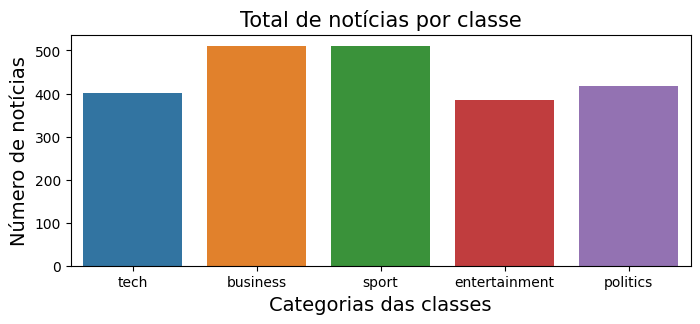

In [8]:
plt.figure(figsize=(8,3))
sns.countplot(data=df, x='category', hue='category')
plt.title("Total de notícias por classe", size=15)
plt.xlabel("Categorias das classes", size=14)
plt.ylabel("Número de notícias", size=14)
plt.show()

## Pré-processamento de texto

In [9]:
# função para a limpeza de texto 

def limpeza_texto(text):
    whitespace = re.compile(r'\s+')
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(" ", text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)                             
    text = re.sub(r'[^\w\s]','',text)                         
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

In [24]:
print('Texto antes da limpeza:\n', df['text'][0])
print('-_'*50)
print('Texto depois da limpeza:\n', limpeza_texto(df['text'][0]))

Texto antes da limpeza:
 tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are als

In [26]:
# aplicando a função no dataframe
df['text'] = df['text'].apply(limpeza_texto)

In [31]:
total_antigo = df_2['text'].apply(len).sum()
total_novo = df['text'].apply(len).sum()

In [34]:
# medindo o total de caracteres do dataframe 
print(f'Tamanho de caracteres do dataframe antigo: {total_antigo}')
print(f'Tamanho de caracteres do dataframe novo: {total_novo}')

Tamanho de caracteres do dataframe antigo: 5035033
Tamanho de caracteres do dataframe novo: 3280729


In [35]:
# medindo o total de palavras do dataframe 

antigo_palavras = df_2['text'].apply(lambda x: len([i for i in x.split()])).sum()
novo_palavras = df['text'].apply(lambda x: len([i for i in x.split()])).sum()

print(f'Total de palavras do dataframe antigo: {antigo_palavras}')
print(f'Total de palavras do dataframe novo: {novo_palavras}')
print(f'Número de palavras removidas durante a limpeza: {antigo_palavras - novo_palavras}')

Total de palavras do dataframe antigo: 868407
Total de palavras do dataframe novo: 488645
Número de palavras removidas durante a limpeza: 379762
